In [1]:
%load_ext autoreload
%autoreload 2

import ipywidgets as widgets
import numpy as np
import os
import pandas as pd
import seaborn as sns

from benchmarks import gsa_svm_fitness
from src.entities import GSA

from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats as st
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from typing import Mapping, Tuple, Union
from ucimlrepo import fetch_ucirepo

In [2]:
uci_datasets = ["Breast Cancer Wisconsin (Diagnostic)",
                "Mushroom",
                "Spambase"]

widget_opt = widgets.Dropdown(options=uci_datasets,
                              description='Dataset: ')

display(widget_opt)

Dropdown(description='Dataset: ', options=('Breast Cancer Wisconsin (Diagnostic)', 'Mushroom', 'Spambase'), va…

In [35]:
def fetch_uci_dataset(dataset_name: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Fetch UCI dataset
    """
    def fetch_categorical_dataset(_id: int) -> Tuple[pd.DataFrame, pd.Series]:
        data = fetch_ucirepo(id=_id)
        X = data.data.features
        y = data.data.targets
        encoder = LabelEncoder()
        for col in X.columns:
            X.loc[:, col] = encoder.fit_transform(X[col])
        return X, y

    if dataset_name == "Breast Cancer Wisconsin (Diagnostic)":
        data = fetch_ucirepo(id=15)
        X = data.data.features
        y = data.data.targets
        X = X.fillna(value=0)
    elif dataset_name == "Spambase":
        X, y = fetch_categorical_dataset(_id=94)
    elif dataset_name == "Mushroom":
        X, y = fetch_categorical_dataset(_id=73)
    
    return X, y

X, y = fetch_uci_dataset(widget_opt.value)

# Name of selected dataset and summary (number of instances, features, etc.)
print(f"Dataset: {widget_opt.value}")
print(f"Instances: {X.shape[0]}")
print(f"Features: {X.shape[1]}")

Dataset: Breast Cancer Wisconsin (Original)
Instances: 699
Features: 9


In [20]:
y.value_counts()

Class
0        2788
1        1813
Name: count, dtype: int64

In [21]:
# WARNING!! GLOBAL VARIABLES
wa = 0.0
wf = 0.0

# IMPORTANT!! MUTABLE GLOBAL VARIABLE
conf_matrix_dict = {"TP": 0, "FP": 0, "TN": 0, "FN": 0}

class UCI:
    """
    Class to handle UCI datasets
    
    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
    """
    def __init__(self,
                 X: pd.DataFrame,
                 y: pd.Series,
                 boundaries: Mapping[str, Tuple[Tuple[float, float], ...]],
                 seed: int=5
                 ) -> None:
        """
        Constructor
        
        Args:
            X (pd.DataFrame): Features
            y (pd.Series): Target
            boundaries (Mapping[str, Tuple[Tuple[float, float], ...]): Boundaries for the optimization problem
            seed (int, optional): Random seed. Defaults to 5.
        """
        self.X = X
        self.y = y
        self.boundaries = boundaries

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.X)
        
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    
    def get_fitness(self,
                    solution: Mapping[str, np.ndarray],
                    data: Union[None, Tuple[np.ndarray, np.ndarray]] = None,
                    show_confusion_matrix: bool=False
                    ) -> Tuple[float, float]:
        """
        Get fitness of a solution
        
        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate
            data (Union[None, Tuple[np.ndarray, np.ndarray]], optional): Data to evaluate the solution. Defaults to None.
        
        Returns:
            Tuple[float, float]: Fitness and accuracy of the solution    
        """
        if data is None:
            X_scaled = self.X_train
            y_data = self.y_train
        else:
            X_scaled, y_data = data
            
        gamma, C = solution['real']
        gamma /= 1_000
        C /= 1_000
        X_scaled_filtered = X_scaled[:, solution['discrete'].astype(int) == 1]
        svc_model = SVC(gamma=gamma, C=C, kernel="rbf", verbose=False)
        svc_model.fit(X_scaled_filtered, np.ravel(y_data))
        y_predict = svc_model.predict(X_scaled_filtered)
        conf_matrix = confusion_matrix(y_data, y_predict)
        if show_confusion_matrix:
            # Update global conf_matrix_dict
            conf_matrix_dict["TP"] = conf_matrix[0, 0]
            conf_matrix_dict["FP"] = conf_matrix[0, 1]
            conf_matrix_dict["TN"] = conf_matrix[1, 1]
            conf_matrix_dict["FN"] = conf_matrix[1, 0]
            print(conf_matrix)
        accuracy = accuracy_score(y_data, y_predict) * 100
        
        return gsa_svm_fitness(accuracy=accuracy, solution=solution, wa=wa, wf=wf)

    def is_feasible(self, solution: Mapping[str, np.ndarray]) -> bool:
        """
        Check if a solution is feasible

        Args:
            solution (Mapping[str, np.ndarray]): Solution to evaluate

        Returns:
            bool: True if the solution is feasible, False otherwise
        """
        real_values = solution['real']
        discrete_values = solution['discrete']

        for i, (min_val, max_val) in enumerate(self.boundaries['real']):
            if real_values[i] < min_val or real_values[i] > max_val:
                return False

        for i, (min_val, max_val) in enumerate(self.boundaries['discrete']):
            if discrete_values[i] < min_val or discrete_values[i] > max_val:
                return False
        
        if sum(discrete_values) == 0:
            return False
        
        return True

boundaries = {'real': [(1, 100_000), (1, 100_000)], 'discrete': [(0, 1) for _ in range(len(X.columns))]}
uci_data = UCI(X, y, boundaries)

In [22]:
from random import randint, seed 

def run_gsa(chaotic_constant: bool=False,
            repair_solution: bool=False,
            runs: int=10,
            population_size: int=5,
            iterations: int=20
            ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    global_train_hist = pd.DataFrame()
    global_test_hist = pd.DataFrame(columns=["run", "accuracy", "fitness", "TP", "FP", "TN", "FN"])
    
    for k in range(runs):
        gsa_seed = randint(0, 1000)
        uci_data = UCI(X, y, boundaries)
        
        gsa_algo = GSA(objective_function = uci_data.get_fitness,
                       is_feasible=uci_data.is_feasible,
                       r_dim=2,
                       d_dim=len(X.columns),
                       boundaries=uci_data.boundaries)
        
        gsa_algo.set_seed(seed=gsa_seed)
        training_history = gsa_algo.optimize(population_size=population_size,
                                             iters=iterations,
                                             chaotic_constant=chaotic_constant,
                                             repair_solution=repair_solution)
        
        training_history.insert(0, "run", k)
        global_train_hist = pd.concat([global_train_hist, training_history], axis=0)
        
        print(gsa_algo.solution_history[-1])
        fitness, accuracy = uci_data.get_fitness(solution=gsa_algo.solution_history[-1],
                                            data=(uci_data.X_test, uci_data.y_test),
                                            show_confusion_matrix=True)
        
        global_test_hist.loc[len(global_test_hist)] = [k, accuracy, fitness, conf_matrix_dict["TP"], conf_matrix_dict["FP"], conf_matrix_dict["TN"], conf_matrix_dict["FN"]]
        
        print("Test accuracy: ", accuracy, " - Fitness: ", fitness)
    
    return global_train_hist, global_test_hist

In [23]:
seed(22)

wa = 0.8
wf = 0.2

train_df, test_df = run_gsa(chaotic_constant=True,
                       runs=10,
                       population_size=5,
                       iterations=20)

GSA is optimizing  "get_fitness"
['At iteration 1 the best fitness is 89.56025934401221']
['At iteration 2 the best fitness is 91.56025934401221']
['At iteration 3 the best fitness is 91.56025934401221']
['At iteration 4 the best fitness is 91.56025934401221']
['At iteration 5 the best fitness is 91.56025934401221']
['At iteration 6 the best fitness is 91.56025934401221']
['At iteration 7 the best fitness is 91.56025934401221']
['At iteration 8 the best fitness is 91.56025934401221']
['At iteration 9 the best fitness is 91.56025934401221']
['At iteration 10 the best fitness is 91.56025934401221']
['At iteration 11 the best fitness is 91.56025934401221']
['At iteration 12 the best fitness is 91.56025934401221']
['At iteration 13 the best fitness is 91.56025934401221']
['At iteration 14 the best fitness is 91.63157894736842']
['At iteration 15 the best fitness is 92.24332570556827']
['At iteration 16 the best fitness is 92.24332570556827']
['At iteration 17 the best fitness is 92.2433257

In [24]:
train_df

,run,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,0,89.560259,97.038043,3.403657,"[[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[53278.608716518494, 86948.94861139914], [412..."
1,0,1,91.560259,99.538043,6.812630,"[[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[53278.608716518494, 86948.94861139914], [412..."
2,0,2,91.560259,99.538043,10.338895,"[[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[53278.608716518494, 86948.94861139914], [412..."
3,0,3,91.560259,99.538043,13.948714,"[[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[53278.608716518494, 86948.94861139914], [412..."
4,0,4,91.560259,99.538043,17.415668,"[[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,...","[[53278.608716518494, 86948.94861139914], [412..."
...,...,...,...,...,...,...,...
15,9,15,92.134630,98.940217,59.402672,"[[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,...","[[944.0679035233848, 8318.115787730865], [7642..."
16,9,16,92.134630,98.940217,62.767850,"[[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,...","[[944.0679035233848, 8318.115787730865], [7642..."
17,9,17,92.134630,98.940217,66.788015,"[[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,...","[[944.0679035233848, 8318.115787730865], [7642..."
18,9,18,92.134630,98.940217,70.811335,"[[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,...","[[944.0679035233848, 8318.115787730865], [7642..."


In [25]:
real_hist = train_df.groupby('run')['Real'].last().apply(lambda x: x[-1])
real_hist

run
0      [28891.15307520256, 63361.74891921197]
1      [63438.24190096487, 7595.773074256971]
2     [31286.007008108347, 96936.67266453375]
3     [76294.67483366912, 1337.4560009830666]
4       [89014.73900849142, 89013.1252153836]
5      [70017.71453539368, 85079.56536868447]
6     [67440.90680095801, 48109.307658411155]
7    [13227.899759881622, 13295.117974343639]
8     [16518.76643390483, 20788.412451877466]
9     [53425.167512452535, 99672.71994081586]
Name: Real, dtype: object

In [26]:
gamma_hist = real_hist.apply(lambda x: x[0]/1000)

mean_gamma = np.round(gamma_hist.mean(), 4)
std_gamma = np.round(gamma_hist.std(), 4)
mean_gamma, std_gamma

(50.9555, 26.6054)

In [27]:
c_hist = real_hist.apply(lambda x: x[1]/1000)

mean_c = np.round(c_hist.mean(), 4)
std_c = np.round(c_hist.std(), 4)
mean_c, std_c

(52.519, 39.3113)

In [28]:
n_features_hist = train_df.groupby('run')['Discrete'].last()
n_features_hist = n_features_hist.apply(lambda x: sum(x[-1]))

# Get mean and std of n_features_hist
mean_n_feat = np.round(n_features_hist.mean())
std_n_feat = np.round(n_features_hist.std())
mean_n_feat, std_n_feat

(27.0, 3.0)

In [29]:
# Group by run, get last value of each group in Accuracy column creating a pd.Series
accuracy_hist = train_df.groupby('run')['Accuracy'].last()

# Get mean and std of accuracy_hist
mean_accuracy = np.round(accuracy_hist.mean(), 4)
std_accuracy = np.round(accuracy_hist.std(), 4)
mean_accuracy, std_accuracy

(99.394, 0.2556)

In [30]:
test_df

,run,accuracy,fitness,TP,FP,TN,FN
0,0.0,99.457112,90.092005,566.0,0.0,350.0,5.0
1,1.0,99.782845,92.106978,569.0,0.0,350.0,2.0
2,2.0,99.565689,92.284131,542.0,0.0,375.0,4.0
3,3.0,99.674267,90.616607,554.0,0.0,364.0,3.0
4,4.0,99.782845,88.949083,580.0,0.0,339.0,2.0
5,5.0,100.000000,90.526316,561.0,0.0,360.0,0.0
6,6.0,99.891422,92.193840,557.0,1.0,363.0,0.0
7,7.0,99.674267,91.669238,563.0,0.0,355.0,3.0
8,8.0,99.674267,90.967484,550.0,0.0,368.0,3.0
9,9.0,97.719870,90.105720,569.0,0.0,331.0,21.0


In [31]:
test_accuracy_hist = test_df['accuracy']

mean_test_accuracy = np.round(test_accuracy_hist.mean(), 4)
std_test_accuracy = np.round(test_accuracy_hist.std(), 4)
mean_test_accuracy, std_test_accuracy

(99.5223, 0.6519)

In [32]:
# Save train and test df with name of dataset

save_path = "../data/output"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
train_df.to_csv(f"{save_path}/{widget_opt.value}_train_df.csv", index=False)
test_df.to_csv(f"{save_path}/{widget_opt.value}_test_df.csv", index=False)

In [4]:
save_path = "../data/output"
train_dfs = {dataset: pd.read_csv(f"{save_path}/{dataset}_train_df.csv") for dataset in uci_datasets}
test_dfs = {dataset: pd.read_csv(f"{save_path}/{dataset}_test_df.csv") for dataset in uci_datasets}

In [5]:
test_dfs[uci_datasets[0]]

,run,accuracy,fitness,TP,FP,TN,FN
0,0.0,98.571429,92.190476,92.0,1.0,46.0,1.0
1,1.0,96.428571,92.698413,82.0,1.0,53.0,4.0
2,2.0,100.000000,88.888889,93.0,0.0,47.0,0.0
3,3.0,97.142857,93.269841,92.0,2.0,44.0,2.0
4,4.0,100.000000,84.444444,95.0,0.0,45.0,0.0
5,5.0,100.000000,88.888889,92.0,0.0,48.0,0.0
6,6.0,100.000000,84.444444,92.0,0.0,48.0,0.0
7,7.0,100.000000,91.111111,90.0,0.0,50.0,0.0
8,8.0,94.285714,88.761905,82.0,3.0,50.0,5.0
9,9.0,100.000000,91.111111,95.0,0.0,45.0,0.0


In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def subplots_centered(nrows, ncols, figsize, nfigs):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.
    
    It returns a grid where the plots
    in the **last** row are centered.
    
    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"
    
    fig = plt.figure(figsize=figsize)
    axs = []
    
    m = nfigs % ncols
    m = range(1, ncols+1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m*ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows-1: # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m*col + off : m*(col+1) + off])
        axs.append(ax)
        
    return fig, axs

/var/folders/_n/lz98rzln403f9jgxhtvhf_wr0000gn/T/ipykernel_16609/2875573573.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(j, i, f"{int(mc_mean[i, j])}\n±{std_series[i * 2 + j]:.2f}\n({pctg} %)",
/var/folders/_n/lz98rzln403f9jgxhtvhf_wr0000gn/T/ipykernel_16609/2875573573.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(j, i, f"{int(mc_mean[i, j])}\n±{std_series[i * 2 + j]:.2f}\n({pctg} %)",
/var/folders/_n/lz98rzln403f9jgxhtvhf_wr0000gn/T/ipykernel_16609/2875573573.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

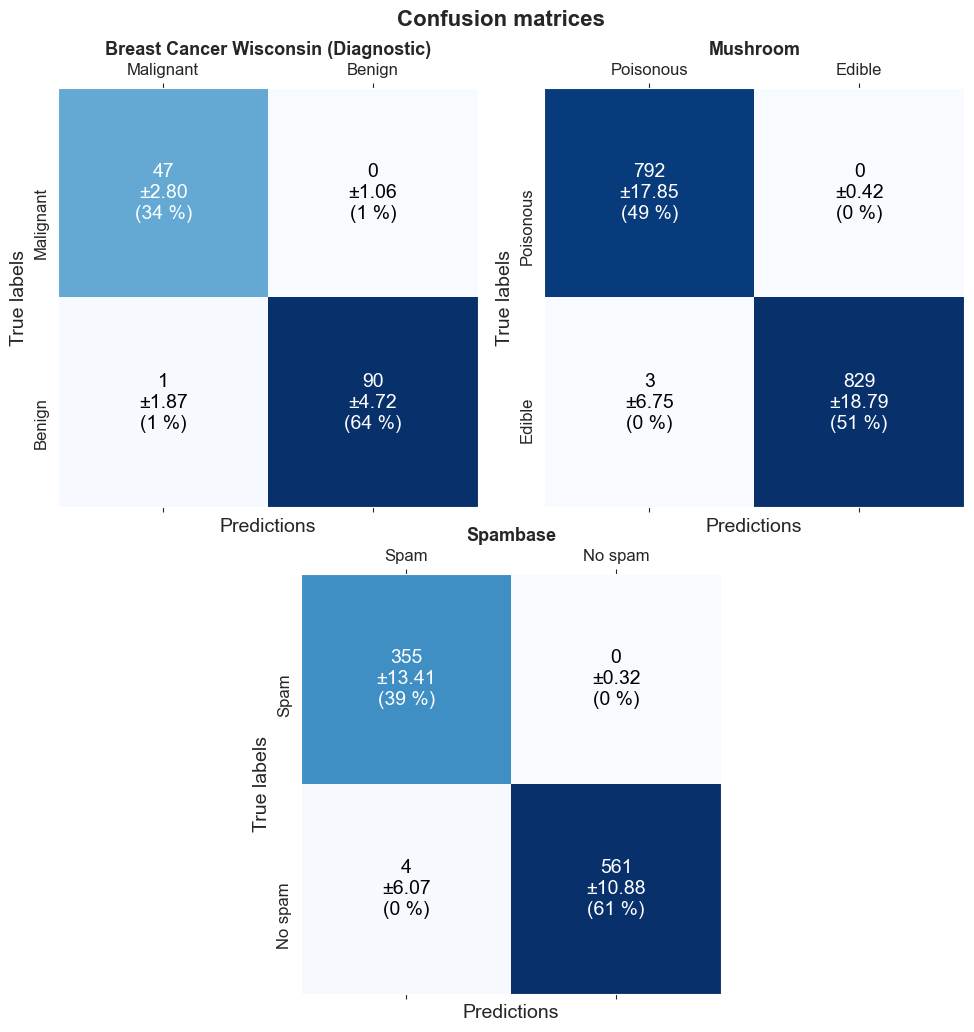

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_conf_plot(ax, dataset, mc_mean, std_series, clases):
    ax.set_facecolor('red')
    cax = ax.matshow(mc_mean, cmap=plt.cm.Blues)
    
    ax.set_title(f"{dataset}", fontsize=13, fontweight='bold')
    total = sum(mc_mean.flatten())
    thresh = mc_mean.max() / 2.
    for i in range(2):
        for j in range(2):
            pctg = round(round(mc_mean[i, j]) / total * 100)
            ax.text(j, i, f"{int(mc_mean[i, j])}\n±{std_series[i * 2 + j]:.2f}\n({pctg} %)",
                    ha='center', va='center', fontsize=14,
                    color="white" if  mc_mean[i, j] == 0 or mc_mean[i, j] > thresh else "black")
    
    ax.grid(False)
    ax.set_xticks(range(2), clases, fontsize=12)
    ax.set_yticks(range(2), clases, rotation=90, fontsize=12)
    ax.set_xlabel('Predictions', fontsize=14)
    ax.set_ylabel('True labels', fontsize=14)
    
    # cbar = plt.colorbar(cax)
    # cbar.set_label('Frequency')

clases = [['Malignant', 'Benign'], ['Poisonous', 'Edible'], ['Spam', 'No spam']]
columns = ['TN', 'FP', 'FN', 'TP']

fig, axs = subplots_centered(nrows=2, ncols=2, figsize=(10,10), nfigs=3)
plt.tight_layout(pad=2.0)

positions = [(0, 0), (1, 0), (1, 1)]
for i, dataset in enumerate(uci_datasets):
    df_conf = test_dfs[dataset][columns]
    
    mean_series = df_conf.mean()
    std_series = df_conf.std()

    mc_mean = mean_series.values.reshape(2, 2)
    get_conf_plot(axs[i], dataset, mc_mean, std_series, clases[i])

fig.suptitle('Confusion matrices', fontsize=16, fontweight='bold', y=1.04)
plt.show()

fig.savefig("../data/output/confusion_matrices.png", dpi=300, bbox_inches='tight')